# Problem statement:
To build a CNN based multiclass classification model which can accurately detect `Melanoma`. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and `alert the dermatologists` about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

To build the model we are using dataset consisting of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC).

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from collections import Counter
from glob import glob
from keras.regularizers import l2

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

#Google Drive Path
data_dir_train = pathlib.Path('/content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Test')

#Local path
#data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
#data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train images:',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test images:',image_count_test)

Train images: 2239
Test images: 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size,

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size,

)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

In [ ]:
%%time
images_per_row = 6

# Visualizing random 6 images per class to see the pattern

# Initialize the dictionary with empty lists for each class
label_image_dict = {i: [] for i in range(9)}

for (image_tensor, label_tensor) in val_ds:
    # Iterate over each class and add images until we reach the limit
    for cls in range(9):
        if len(label_image_dict[cls]) >= images_per_row:
            continue

        # Find positions where the current class is present in the batch
        pos = tf.where(label_tensor == cls).numpy()

        for idx in pos:
            if len(label_image_dict[cls]) < images_per_row:
                image = image_tensor[idx[0]].numpy()
                label_image_dict[cls].append(image / 255)

    # Check if all classes have enough images and break if so
    if all(len(images) >= images_per_row for images in label_image_dict.values()):
        break

CPU times: user 2.16 s, sys: 224 ms, total: 2.38 s
Wall time: 1min 21s


In [ ]:
images_per_row = 6

# Iterate over each label and its corresponding images
for label, image_list in label_image_dict.items():
    # Create a new figure for the current label
    fig, axes = plt.subplots(1, images_per_row, figsize=(13, 3))
    fig.suptitle(val_ds.class_names[label], fontsize=20)

    # Iterate over the images and the corresponding subplot axes
    for ax, img in zip(axes, image_list):
        ax.imshow(img)
        #ax.set_title(val_ds.class_names[label], fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for ax in axes[len(image_list):]:
       ax.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

###

### Create the base model 1
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

basemodel = Sequential()
basemodel.add(layers.Rescaling(1./255, input_shape=(180,180,3)))

basemodel.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))

basemodel.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))

basemodel.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))

basemodel.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel.add(MaxPooling2D(pool_size=(2, 2)))

basemodel.add(Flatten())

#Fully Connected networks
basemodel.add(Dense(128, activation='relu'))

#Softmax layer
basemodel.add(Dense(9, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
basemodel.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
basemodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [ ]:
epochs = 20
history = basemodel.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.1707 - loss: 2.0980 - val_accuracy: 0.2058 - val_loss: 2.0281
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 58s 37ms/step - accuracy: 0.2104 - loss: 1.9999 - val_accuracy: 0.1924 - val_loss: 2.0243
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1903 - loss: 2.0356 - val_accuracy: 0.2013 - val_loss: 2.0120
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.1961 - loss: 2.0092 - val_accuracy: 0.1924 - val_loss: 2.0099
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2264 - loss: 2.0202 - val_accuracy: 0.2931 - val_loss: 1.9984
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2579 - loss: 2.0036 - val_accuracy: 0.2841 - val_loss: 1.9790
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2689 - loss: 1.9764 - val_accuracy: 0.3333 - val_loss: 1.9539
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2665 - loss: 1.9518 - val_accuracy: 0.2953 - 

#### Visualizing training results

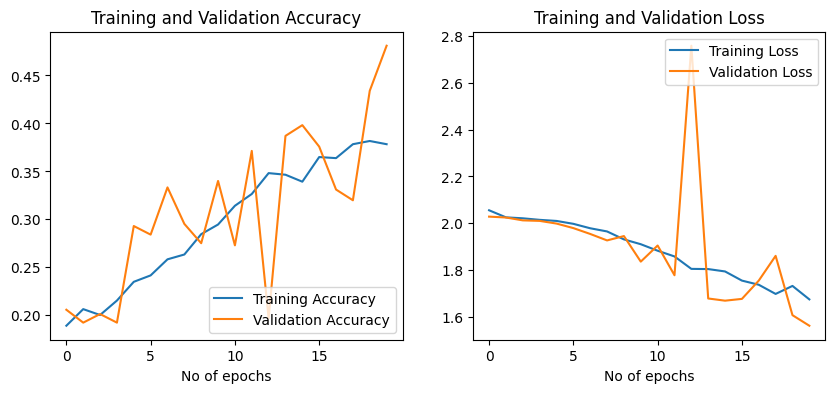

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Base Model 1 evaluation on test dataset

In [47]:
#Loading the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

Found 118 files belonging to 9 classes.


In [ ]:
for img, label in test_ds:
    print(img.shape)
print('No of batches in the test dataset')

(32, 180, 180, 3)
(32, 180, 180, 3)
(32, 180, 180, 3)
(22, 180, 180, 3)
No of batches in the test dataset


In [ ]:
#Using model method to check the test accuracy
basemodel.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3134 - loss: 2.0661


[2.014188289642334, 0.29661017656326294]

In [ ]:
#Manual Calculation of accuracy
prediction = basemodel.predict(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 995ms/step


In [ ]:
prediction.shape

(118, 9)

In [ ]:
predicted_label = np.argmax(prediction,axis=1)

In [ ]:
true_label = tf.concat([label for img, label in test_ds], axis=0)

In [ ]:
np.sum(true_label == predicted_label)/len(true_label)

0.2966101694915254

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

1. The model is not completely converged with 20 epochs with SGD optimizer. The training accuracy is 36% and validation accuracy is 48%. The model underfits for 20 epochs.
2. There is lot of fluctions while converging to the optimum value and this indicates noise in the data, also due to the nature of SGD.
3. The validation accuracy is higher than training accuracy. This indicates the model has failed to learn the pattern.
4. The model is giving 29% of accuracy on the test dataset.

So, going to train one more base model with different optimizer to check the results.


### Create the base model 2

In [ ]:
###
basemodel2 = Sequential()
basemodel2.add(layers.Rescaling(1./255, input_shape=(180,180,3)))

basemodel2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel2.add(MaxPooling2D(pool_size=(2, 2)))

basemodel2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel2.add(MaxPooling2D(pool_size=(2, 2)))

basemodel2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel2.add(MaxPooling2D(pool_size=(2, 2)))

basemodel2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
basemodel2.add(MaxPooling2D(pool_size=(2, 2)))

basemodel2.add(Flatten())

#Fully Connected networks
basemodel2.add(Dense(128, activation='relu'))

#Softmax layer
basemodel2.add(Dense(9, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
### Todo, choose an appropirate optimiser and loss function
basemodel2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
basemodel2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training the model
epochs = 20
history2 = basemodel2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.1573 - loss: 2.1754 - val_accuracy: 0.1924 - val_loss: 1.9970
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.2375 - loss: 1.9857 - val_accuracy: 0.3579 - val_loss: 1.7783
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3762 - loss: 1.7434 - val_accuracy: 0.4609 - val_loss: 1.6038
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4152 - loss: 1.6732 - val_accuracy: 0.4251 - val_loss: 1.6340
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4600 - loss: 1.5341 - val_accuracy: 0.4966 - val_loss: 1.4673
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4789 - loss: 1.5070 - val_accuracy: 0.5168 - val_loss: 1.4100
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5298 - loss: 1.3272 - val_accuracy: 0.5369 - val_loss: 1.3781
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5051 - loss: 1.3785 - val_accuracy: 0.5302 - v

#### Visualizing the basemodel2 results:

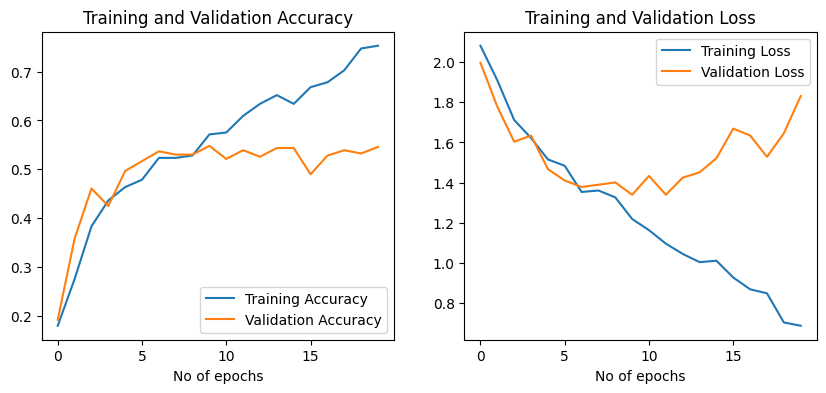

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('No of epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('No of epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Base Model 2 evaluation on test dataset

In [ ]:
basemodel2.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4041 - loss: 3.5112


[3.6680471897125244, 0.43220338225364685]

#### Write your findings here

__Findings__

1. The model tends to overfit with ADAM optimizer. The training accuracy is about 75% and validation accuracy is about 50%
2. As compared to SGD optimizer, ADAM optimizer has converged quickly with same CNN architecture.
3. The ADAM optimizer seems have handled the fluctuations.
4. The model is giving 43% accuracy on the test dataset. There is an improvement in the result with ADAM optimizer.

So, going to use ADAM as a primary optimizer for next set of experiments.

### Data Augmentation

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation1 = Sequential( [
                                layers.Rescaling(1./255, input_shape=(180,180,3)),
                                layers.RandomFlip("horizontal_and_vertical"),
                                #layers.RandomRotation(0.2),
                                layers.RandomZoom(0.2),
                                #layers.RandomContrast(0.2),
                                #layers.RandomTranslation(0.2, 0.2)
                                ]
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


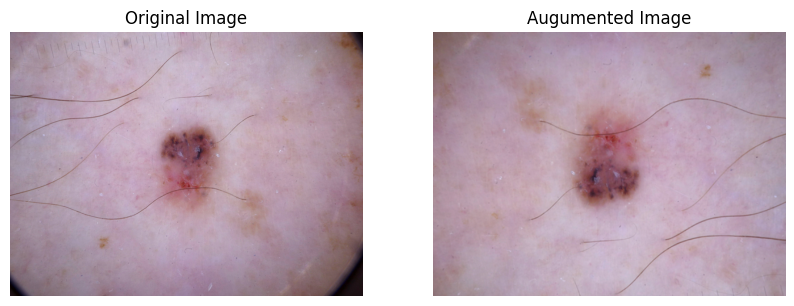

<Figure size 640x480 with 0 Axes>

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
temp = plt.imread(list(data_dir_train.glob('*/*.jpg'))[283])
#temp = PIL.Image.open(list(data_dir_train.glob('*/*.jpg'))[0])
plt.axis('off')
plt.imshow(temp)
plt.title('Original Image')

plt.subplot(1,2,2)
#tempD = tf.image.resize(temp,[180,180])
tempD = tf.expand_dims(temp, axis=0)
tempD = data_augmentation1(tempD)
tempD = tf.squeeze(tempD,axis=0)
plt.axis('off')
plt.title('Augumented Image')
plt.imshow(tempD)
plt.show()
plt.tight_layout()




In [ ]:
temp.shape, tempD.shape

((450, 600, 3), TensorShape([450, 600, 3]))

#### Todo: Create a Model
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes her
model = Sequential()
model.add(layers.Input(shape=(180,180,3))),
model.add(data_augmentation1)

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

#Fully Connected networks
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

#Softmax layer
model.add(Dense(9, activation='softmax'))



#### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_da = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.1841 - loss: 2.3828 - val_accuracy: 0.2058 - val_loss: 2.0794
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2055 - loss: 2.0466 - val_accuracy: 0.2058 - val_loss: 2.0516
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1865 - loss: 2.0348 - val_accuracy: 0.2260 - val_loss: 2.0089
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2322 - loss: 1.9980 - val_accuracy: 0.3445 - val_loss: 1.7846
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.3379 - loss: 1.8322 - val_accuracy: 0.3490 - val_loss: 1.8277
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3388 - loss: 1.7688 - val_accuracy: 0.3826 - val_loss: 1.6774
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4047 - loss: 1.6358 - val_accuracy: 0.4497 - val_loss: 1.5760
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.4215 - loss: 1.6004 - val_accuracy: 0.4228 - v

#### Visualizing the results

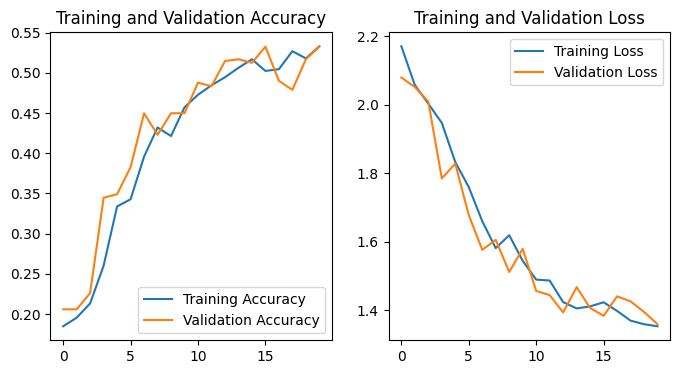

In [ ]:
acc = history_da.history['accuracy']
val_acc = history_da.history['val_accuracy']

loss = history_da.history['loss']
val_loss = history_da.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Model evaluation on Test dataset

In [ ]:
model.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3406 - loss: 2.1391


[2.0544300079345703, 0.3644067943096161]

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Data augmentation stratergy used: RandomFlip("horizontal_and_vertical") and RandomZoom.

1. With 20 epochs, and 'adam' as optimizer, post data agumentation, training accuracy is 52% and validation accuracy is 53%.
2. As compared to previous model, high variance seems to be handled post data augmentation.
3. Test accuracy has dropped to 36%.


### Data Augmentation 2

In [ ]:
data_augmentation2 = Sequential( [
                                layers.Rescaling(1./255, input_shape=(180,180,3)),
                                #layers.RandomFlip("horizontal_and_vertical"),
                                layers.RandomRotation(0.2),
                                #layers.RandomZoom(0.2),
                                layers.RandomContrast(0.2),
                                layers.RandomTranslation(0.2, 0.2)
                                ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes her
model_da2 = Sequential()
model_da2.add(layers.Input(shape=(180,180,3))),
model_da2.add(data_augmentation2)

model_da2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model_da2.add(MaxPooling2D(pool_size=(2, 2)))
model_da2.add(Dropout(0.2))

model_da2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model_da2.add(MaxPooling2D(pool_size=(2, 2)))
model_da2.add(Dropout(0.2))

model_da2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model_da2.add(MaxPooling2D(pool_size=(2, 2)))
model_da2.add(Dropout(0.2))

model_da2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model_da2.add(MaxPooling2D(pool_size=(2, 2)))
model_da2.add(Dropout(0.2))

model_da2.add(Flatten())

#Fully Connected networks
model_da2.add(Dense(128, activation='relu'))
model_da2.add(Dropout(0.5))

#Softmax layer
model_da2.add(Dense(9, activation='softmax'))

In [ ]:
#Model compilation
model_da2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model_da2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history_da2 = model_da2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.1633 - loss: 2.3876 - val_accuracy: 0.2058 - val_loss: 2.1020
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1954 - loss: 2.0647 - val_accuracy: 0.2260 - val_loss: 2.0582
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2144 - loss: 2.0357 - val_accuracy: 0.2058 - val_loss: 2.0415
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.1947 - loss: 2.0589 - val_accuracy: 0.3020 - val_loss: 2.0324
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.2019 - loss: 2.0259 - val_accuracy: 0.3087 - val_loss: 1.8903
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2933 - loss: 1.9167 - val_accuracy: 0.3400 - val_loss: 1.8155
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.3363 - loss: 1.8226 - val_accuracy: 0.3445 - val_loss: 1.7143
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.3504 - loss: 1.7220 - val_accuracy: 0.4049 - v

#### Data Augmentation 2 - evaluation on test set

In [ ]:
model_da2.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2311 - loss: 2.3551


[2.275604724884033, 0.26271185278892517]

Data Augmentation Stratergy used:
RandomRotation, Random Contrast and Random Translation

1. As compared to Data Augmentation stratergy1, with DA2, the model performance has gone down by 5%. The training accuracy is 47%.
2. The test accuracy has dropped to 26%.



## Class Imbalance

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
#Counting the number of images per class using train_ds

label_class_cnt = Counter()
for img, label in train_ds:
    unq_per_batch, label_cnt_per_batch =  np.unique(label,return_counts=True)
    label_class_cnt.update(dict(zip(unq_per_batch, label_cnt_per_batch)))

label_class_cnt = dict(sorted(label_class_cnt.items()))


In [ ]:
for label, img_cnt in label_class_cnt.items():
    print('{0} has {1} images'.format(class_names[label],img_cnt))

print('\nTotal training images: ',sum(label_class_cnt.values()))

actinic keratosis has 92 images
basal cell carcinoma has 309 images
dermatofibroma has 77 images
melanoma has 352 images
nevus has 277 images
pigmented benign keratosis has 370 images
seborrheic keratosis has 58 images
squamous cell carcinoma has 142 images
vascular lesion has 115 images

Total training images:  1792


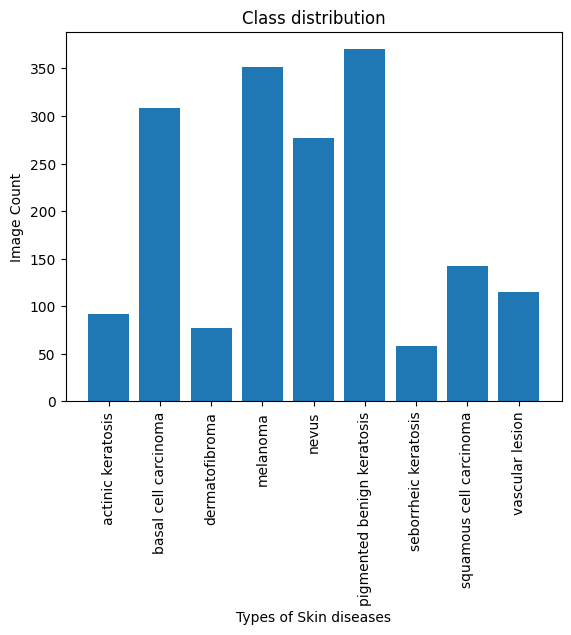

In [ ]:
#Visualizing the distribution
plt.bar(label_class_cnt.keys(), label_class_cnt.values())
plt.title('Class distribution')
plt.xticks(range(9),class_names, rotation=90)
plt.xlabel('Types of Skin diseases')
plt.ylabel('Image Count')
plt.show()

#### **Todo:** Write your findings here:

There is clear indication of class imbalance in the train dataset with 58 being least and pigmented benign keratosis having 370 samples.

#### - Which class has the least number of samples?
Seborrheic keratosis has only 58 samples there by being the class with least no of samples.

#### - Which classes dominate the data in terms proportionate number of samples?

Pigmented benign keratosis having 370 samples is dominating the rest of the classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [13]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
#Code to delete the augmented images in the output folder
# This code was used to test multiple runs with different augmentation combinations
def delete_folder(folder_path):
    for item in folder_path.iterdir():
        if item.is_dir():
            delete_folder(item)
        else:
            item.unlink()
    folder_path.rmdir()

In [29]:
path_to_training_dataset="/content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/"
temp = pathlib.Path(path_to_training_dataset)

In [30]:
for i in list(temp.glob('*/output')):
    print(delete_folder(i))

None
None
None
None
None
None
None
None
None


Following combination gave good results

In [31]:
path_to_training_dataset="/content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    #p.flip_left_right(probability=0.5)
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
    #p.zoom_random(probability=0.5, percentage_area=0.8)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79612483A4D0>: 100%|██████████| 500/500 [00:21<00:00, 22.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7960AA1690F0>: 100%|██████████| 500/500 [00:20<00:00, 24.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79612483A4D0>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7960AA17AF80>: 100%|██████████| 500/500 [01:34<00:00,  5.29 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=767x576 at 0x7960AA1E2260>: 100%|██████████| 500/500 [01:37<00:00,  5.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796122D1EE90>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7960AA178280>: 100%|██████████| 500/500 [00:43<00:00, 11.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x796123FB2230>: 100%|██████████| 500/500 [00:19<00:00, 25.46 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/MelanomaDetection_Assignment/ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79612483A590>: 100%|██████████| 500/500 [00:20<00:00, 24.44 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [37]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
#data_dir_train = pathlib.Path('/content/gdrive/MyDrive/MelanomaDetection_Assignment/ISIC/Train/')

In [39]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [41]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model1

#### **Todo:** Create your model (make sure to include normalization)

In [42]:
## your code goes here
model1 = Sequential()
model1.add(layers.Input(shape=(180,180,3))),
model1.add(layers.Rescaling(1./255))

model1.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Flatten())

#Fully Connected networks
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))


#Softmax layer
model1.add(Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
## your code goes here
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │      15,860,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,382,281 (62.49 MB)

 Trainable params: 16,382,281 (62.49 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [44]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 65s 157ms/step - accuracy: 0.1308 - loss: 2.2472 - val_accuracy: 0.2101 - val_loss: 2.0153
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.2397 - loss: 1.9394 - val_accuracy: 0.3148 - val_loss: 1.8190
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.3037 - loss: 1.7944 - val_accuracy: 0.3734 - val_loss: 1.5831
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3701 - loss: 1.6401 - val_accuracy: 0.4298 - val_loss: 1.5178
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.3953 - loss: 1.5743 - val_accuracy: 0.4477 - val_loss: 1.4050
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4272 - loss: 1.4963 - val_accuracy: 0.4091 - val_loss: 1.4871
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4418 - loss: 1.4222 - val_accuracy: 0.4937 - val_loss: 1.2629
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4832 - loss: 1.3318 - val

#### **Todo:**  Visualize the model results

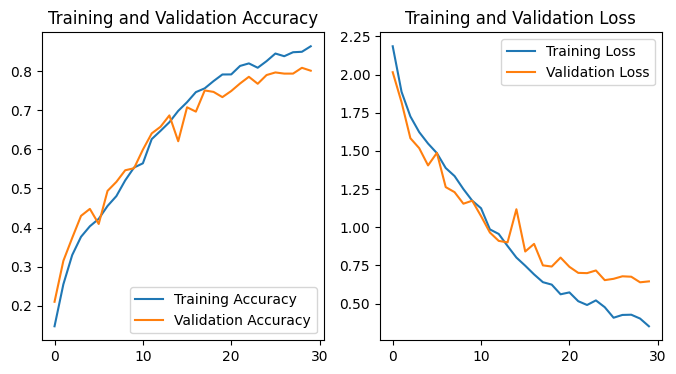

In [45]:
acc = history_aug1.history['accuracy']
val_acc = history_aug1.history['val_accuracy']

loss = history_aug1.history['loss']
val_loss = history_aug1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [48]:
model1.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.4502 - loss: 3.7221


[3.56732439994812, 0.47457626461982727]

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



1. Post data balancing, the training accuracy is about 84% and validation accuracy is 79%.

2. The model's prediction on test data set is 47% which is better compared to previous models.

### Model 2

In [49]:
## your code goes here
model2 = Sequential()
model2.add(layers.Input(shape=(180,180,3))),
model2.add(layers.Rescaling(1./255))

model2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())

#Fully Connected networks
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))


#Softmax layer
model2.add(Dense(9, activation='softmax'))

In [50]:
## your code goes here
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,320,841 (31.74 MB)

 Trainable params: 8,320,841 (31.74 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.1496 - loss: 2.2541 - val_accuracy: 0.2680 - val_loss: 1.9129
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.2854 - loss: 1.8651 - val_accuracy: 0.4143 - val_loss: 1.6305
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.3754 - loss: 1.6503 - val_accuracy: 0.3994 - val_loss: 1.5621
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.4093 - loss: 1.5410 - val_accuracy: 0.4432 - val_loss: 1.4278
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.4174 - loss: 1.5404 - val_accuracy: 0.4462 - val_loss: 1.4020
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4586 - loss: 1.4184 - val_accuracy: 0.5056 - val_loss: 1.2863
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4963 - loss: 1.3117 - val_accuracy: 0.5145 - val_loss: 1.2692
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.5050 - loss: 1.2721 - val_acc

#### Test evaluation

In [52]:
model2.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3161 - loss: 4.1977


[4.116451740264893, 0.3813559412956238]

1. Training accuracy slightly improved but validation accuracy remains same post removing 512 fully connected layer

2. Test accuracy dropped to 38%.

### Model 3

In [53]:
## your code goes here
model3 = Sequential()
model3.add(layers.Input(shape=(180,180,3))),
model3.add(layers.Rescaling(1./255))

model3.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))

model3.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.2))


model3.add(Flatten())

#Fully Connected networks
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))


#Softmax layer
model3.add(Dense(9, activation='softmax'))

In [54]:
## your code goes here
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      15,859,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,955,529 (60.87 MB)

 Trainable params: 15,955,529 (60.87 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1524 - loss: 2.9408 - val_accuracy: 0.3378 - val_loss: 1.8016
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3450 - loss: 1.7479 - val_accuracy: 0.4009 - val_loss: 1.4838
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.3927 - loss: 1.5842 - val_accuracy: 0.4729 - val_loss: 1.4195
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4435 - loss: 1.4501 - val_accuracy: 0.4722 - val_loss: 1.3149
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4933 - loss: 1.3592 - val_accuracy: 0.5167 - val_loss: 1.2933
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5041 - loss: 1.2910 - val_accuracy: 0.5464 - val_loss: 1.2303
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5543 - loss: 1.1776 - val_accuracy: 0.5308 - val_loss: 1.2333
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5792 - loss: 1.1431 - val_

#### Test evaluation

In [56]:
model3.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3554 - loss: 4.9211


[4.63814640045166, 0.37288135290145874]

1. Training accuracy remains around 85% post removal of convolutional layer 256.
2. Test accuracy is about 37% with a marginal increment.

### Model 4

In [57]:
## your code goes here
model4 = Sequential()
model4.add(layers.Input(shape=(180,180,3))),
model4.add(layers.Rescaling(1./255))

model4.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())

#Fully Connected networks
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))


#Softmax layer
model4.add(Dense(9, activation='softmax'))

In [58]:
## your code goes here
model4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,633 (16.61 MB)

 Trainable params: 4,354,633 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug4 = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.1561 - loss: 2.1883 - val_accuracy: 0.3207 - val_loss: 1.8172
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.3232 - loss: 1.8153 - val_accuracy: 0.4039 - val_loss: 1.5445
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.3552 - loss: 1.6452 - val_accuracy: 0.4291 - val_loss: 1.4736
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4149 - loss: 1.5738 - val_accuracy: 0.4091 - val_loss: 1.5499
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.4149 - loss: 1.5291 - val_accuracy: 0.4083 - val_loss: 1.5444
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4214 - loss: 1.4831 - val_accuracy: 0.4699 - val_loss: 1.3655
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.4360 - loss: 1.4644 - val_accuracy: 0.4469 - val_loss: 1.4492
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.4260 - loss: 1.4353 - va

#### Test evaluation

In [60]:
model4.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4002 - loss: 3.7099


[3.7537484169006348, 0.4067796468734741]

### Model 5

In [61]:
## your code goes here
model5 = Sequential()
model5.add(layers.Input(shape=(180,180,3))),
model5.add(layers.Rescaling(1./255))

model5.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))

model5.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Dropout(0.2))

model5.add(Flatten())

#Fully Connected networks
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))


#Softmax layer
model5.add(Dense(9, activation='softmax'))

In [62]:
## your code goes here
model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 45, 45, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,218,153 (31.35 MB)

 Trainable params: 8,218,153 (31.35 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug5 = model5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 157ms/step - accuracy: 0.1279 - loss: 2.2545 - val_accuracy: 0.1403 - val_loss: 2.1871
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.1399 - loss: 2.1800 - val_accuracy: 0.1403 - val_loss: 2.1877
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.1484 - loss: 2.1814 - val_accuracy: 0.1366 - val_loss: 2.1881
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.1414 - loss: 2.1791 - val_accuracy: 0.1403 - val_loss: 2.1870
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.1515 - loss: 2.1752 - val_accuracy: 0.1403 - val_loss: 2.1882
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.1490 - loss: 2.1774 - val_accuracy: 0.1403 - val_loss: 2.1862
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.1513 - loss: 2.1747 - val_accuracy: 0.1403 - val_loss: 2.1872
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.1359 - loss: 2.1765 -

#### Test evaluation

In [64]:
model5.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.0876 - loss: 2.1818


[2.1727936267852783, 0.1355932205915451]

1. Adding more back to back Feature maps, didn't help rather the training accuracy dropped significantly to 13% and validation accuracy is about 14%.

2. Test accuracy dropped to 13%.

### Model 6

In [65]:
## your code goes here
model6 = Sequential()
model6.add(layers.Input(shape=(180,180,3))),
model6.add(layers.Rescaling(1./255))

model6.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Dropout(0.2))

model6.add(Flatten())

#Fully Connected networks
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.5))


#Softmax layer
model6.add(Dense(9, activation='softmax'))

In [66]:
## your code goes here
model6.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,025,161 (30.61 MB)

 Trainable params: 8,024,777 (30.61 MB)

 Non-trainable params: 384 (1.50 KB)

In [67]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug6 = model6.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.1390 - loss: 8.4123 - val_accuracy: 0.1039 - val_loss: 194.7023
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.1484 - loss: 2.1858 - val_accuracy: 0.1366 - val_loss: 134.6188
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.1420 - loss: 2.1818 - val_accuracy: 0.1292 - val_loss: 73.5445
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.1419 - loss: 2.1788 - val_accuracy: 0.1373 - val_loss: 54.2324
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.1349 - loss: 2.1795 - val_accuracy: 0.1388 - val_loss: 50.6631
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.1436 - loss: 2.1756 - val_accuracy: 0.1403 - val_loss: 49.3087
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.1398 - loss: 2.1789 - val_accuracy: 0.1411 - val_loss: 49.7273
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.1478 - loss: 2

#### Test evaluation

In [68]:
model6.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0743 - loss: 48.0040


[43.51369857788086, 0.0762711837887764]

1. Keeping batch normalization didn't improve the model, training accuracy remained at 14%.

2. The test accuracy dropped to 0.7% which is nothing but a random guess.

### Model 7

In [113]:
## your code goes here
model7 = Sequential()
model7.add(layers.Input(shape=(180,180,3))),
model7.add(layers.Rescaling(1./255))

model7.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2)))
model7.add(Dropout(0.2))

model7.add(Flatten())

#Fully Connected networks
model7.add(Dense(128, activation='relu'))
model7.add(Dropout(0.5))


#Softmax layer
model7.add(Dense(9, activation='softmax'))

In [114]:
## your code goes here
model7.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model7.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_9 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,208,265 (12.24 MB)

 Trainable params: 3,208,265 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

In [115]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug7 = model7.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.1278 - loss: 2.2079 - val_accuracy: 0.1403 - val_loss: 2.1857
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.1557 - loss: 2.1698 - val_accuracy: 0.2732 - val_loss: 1.8978
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.2750 - loss: 1.9046 - val_accuracy: 0.3393 - val_loss: 1.6903
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3315 - loss: 1.7452 - val_accuracy: 0.3942 - val_loss: 1.6572
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.3645 - loss: 1.6751 - val_accuracy: 0.3927 - val_loss: 1.5098
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.3602 - loss: 1.6220 - val_accuracy: 0.4024 - val_loss: 1.5172
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.4007 - loss: 1.5337 - val_accuracy: 0.4425 - val_loss: 1.4158
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3922 - loss: 1.5258 - val_

#### Test evaluation

In [116]:
model7.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3322 - loss: 2.4939


[2.3863444328308105, 0.3644067943096161]

1. Moving back to simple model with additional 512 convolutional layer didn't help in the improvement of training accuracy.

2. Test set accuracy is about 36%.

### Model 8

In [71]:
## your code goes here
model8 = Sequential()
model8.add(layers.Input(shape=(180,180,3))),
model8.add(layers.Rescaling(1./255))

model8.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Conv2D(1024, kernel_size=(3, 3), padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(Dropout(0.2))

model8.add(Flatten())

#Fully Connected networks
model8.add(Dense(128, activation='relu'))
model8.add(Dropout(0.5))



#Softmax layer
model8.add(Dense(9, activation='softmax'))

In [72]:
## your code goes here
model8.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 5, 5, 1024)          │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 2, 2, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 2, 2, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 6,813,769 (25.99 MB)

 Trainable params: 6,813,769 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
epochs = 30
## Your code goes here, use 50 epochs.
history_aug8 = model8.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 165ms/step - accuracy: 0.1182 - loss: 2.2201 - val_accuracy: 0.1366 - val_loss: 2.1658
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.1679 - loss: 2.1437 - val_accuracy: 0.1403 - val_loss: 2.1872
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.1501 - loss: 2.1764 - val_accuracy: 0.1633 - val_loss: 2.1455
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.1817 - loss: 2.0777 - val_accuracy: 0.3430 - val_loss: 1.7091
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.3161 - loss: 1.7768 - val_accuracy: 0.3875 - val_loss: 1.5887
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3689 - loss: 1.6731 - val_accuracy: 0.4291 - val_loss: 1.5093
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.3910 - loss: 1.5857 - val_accuracy: 0.4447 - val_loss: 1.4021
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.4131 - loss: 1.4982 - va

#### Test evaluation

In [74]:
model8.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.4135 - loss: 2.8891


[2.719312906265259, 0.43220338225364685]

1. Further adding one more convolutional layer 1024, didn't help in improvement of training accuracy.

2. But the prediction on test data shows improvement with 43% of accuracy.

## Conclusion:

Compared to all the models, post balancing the class model1 with 4 convolutional layers having Maxpooling with dropout, and two fully connected layer gave training accuracy of 86% and validation accuracy of 80%.

Further, model predicted accuracy on test is 4&%

__Visualizing the results from the best model:__

In [90]:
model1.save('model_simple.keras')

In [75]:
model1.evaluate(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4502 - loss: 3.7221


[3.56732439994812, 0.47457626461982727]

In [76]:
result = model1.predict(test_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


In [86]:
class_lab = test_ds.class_names

In [120]:
for images, labels in test_ds.take(3):
    if np.any(labels == 3):
       predictions = model1.predict(images)
       predicted_classes = np.argmax(predictions, axis=1)
       probabilities = np.max(predictions, axis=1)
       break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [129]:
def plot_images(images, labels, predictions, probabilities):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_lab[labels[i]]
        predicted_label = class_lab[predictions[i]]
        confidence = probabilities[i]
        plt.title(f'True: {true_label}\nPred: {predicted_label}\n({confidence:.2f})')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

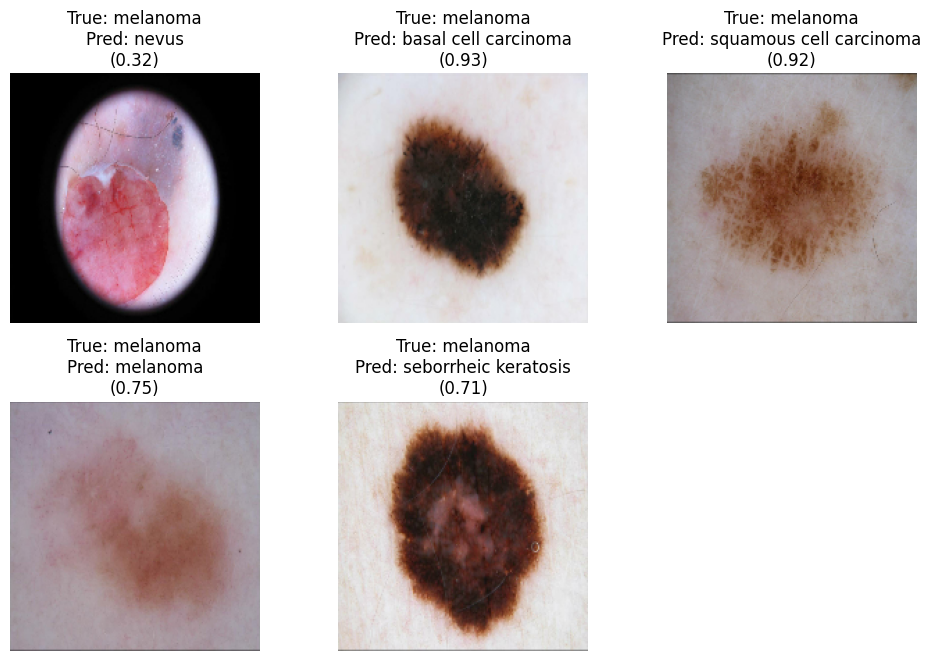

In [134]:
plot_images(images[-15:-10], labels[-15:-10], predicted_classes, probabilities)